<a href="https://colab.research.google.com/github/atanasiusps/Machine-Learning/blob/main/UAS/UAS_ClassificationModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Tahap 1 : Memuat dan Menampilkan Dataset

In [ ]:
import pandas as pd

# Membaca file CSV dengan penanganan baris rusak
df = pd.read_csv("KlasifikasiUTS.csv", on_bad_lines='skip', engine='python')

# Menampilkan 5 baris pertama dari dataset
print("Lima baris pertama dari dataset:")
print(df.head())

# Menampilkan informasi umum tentang dataset
print("\nInformasi dataset:")
print(df.info())

# Menampilkan jumlah nilai yang hilang
print("\nJumlah nilai yang hilang pada setiap kolom:")
print(df.isnull().sum())

# Menampilkan statistik deskriptif
print("\nStatistik deskriptif:")
print(df.describe(include='all'))


Lima baris pertama dari dataset:
   Time        V1        V2        V3        V4        V5        V6        V7  \
0     0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1     0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2     1 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3     1 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4     2 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   


### Menghapus Baris yang Kosong

In [ ]:
import pandas as pd

# Baca ulang file CSV
df = pd.read_csv("KlasifikasiUTS.csv", on_bad_lines='skip', engine='python')

# Ubah semua kolom ke float (angka), jika gagal jadi NaN
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Tampilkan jumlah missing value
print("Jumlah nilai yang hilang per kolom:")
print(df.isnull().sum())

# Hapus semua baris yang mengandung missing value
df_clean = df.dropna()

# Tampilkan ukuran dataset setelah dibersihkan
print("\nUkuran dataset setelah pembersihan:", df_clean.shape)

# Tampilkan distribusi label target
print("\nDistribusi label (Class):")
print(df_clean['Class'].value_counts())

# (Opsional) Simpan ke file baru
df_clean.to_csv("KlasifikasiUTS_clean.csv", index=False)


Jumlah nilai yang hilang per kolom:
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       1
V11       1
V12       1
V13       1
V14       1
V15       1
V16       1
V17       1
V18       1
V19       1
V20       1
V21       1
V22       1
V23       1
V24       1
V25       1
V26       1
V27       1
V28       1
Amount    1
Class     1
dtype: int64

Ukuran dataset setelah pembersihan: (63471, 31)

Distribusi label (Class):
Class
0.0    63306
1.0      165
Name: count, dtype: int64


### Feature Engineering
Tujuan :    
- Normalisasi fitur numerik (StandardScaler).
- Encoding fitur kategorikal (jika ada).
- Pisahkan data latih dan uji.



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
import numpy as np

X = df.drop(columns=['Class'])
y = df['Class']

# Cek lagi (kalau belum dilakukan)
num_features = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
cat_features = X.select_dtypes(include=['object']).columns.tolist()

# Pipeline numerik: imputasi + scaling
numeric_pipeline = Pipeline(steps=[
    ("scaler", StandardScaler())
])

# Pipeline kategorikal (kalau ada)
if cat_features:
    categorical_pipeline = Pipeline(steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ])

    # Gabungkan kedua transformasi
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_pipeline, num_features),
            ("cat", categorical_pipeline, cat_features)
        ])
else:
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_pipeline, num_features)
        ])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Transformasikan data
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)

print("Ukuran X_train setelah transformasi:", X_train_proc.shape)
print("Ukuran X_test setelah transformasi:", X_test_proc.shape)


Ukuran X_train setelah transformasi: (50777, 30)
Ukuran X_test setelah transformasi: (12695, 30)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Arsitektur model MLP
def build_mlp(input_dim):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(32, activation='relu'),
        layers.Dense(1)  # output regresi
    ])
    return model

# Callback
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

# Bangun dan compile model
model = build_mlp(X_train.shape[1])
model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-4),
    loss='mse',
    metrics=['mae']
)

# Training
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=64,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/100
635/635 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan - learning_rate: 0.0010
Epoch 2/100
635/635 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan - learning_rate: 0.0010
Epoch 3/100
635/635 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan - learning_rate: 0.0010
Epoch 4/100
635/635 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan - learning_rate: 0.0010
Epoch 5/100
635/635 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan - learning_rate: 0.0010
Epoch 6/100
635/635 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan - learning_rate: 5.0000e-04
Epoch 7/100
635/635 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan - learning_rate: 5.0000e-04
Epoch 8/100
635/635 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: nan - mae: n

### Penjelasan
Training menghasilkan NaN (Not a Number) karena ada masalah dalam input atau target yang menyebabkan perhitungan loss menjadi tak terdefinisi.

Penyebab umum :    
1. Nilai NaN atau Inf di X_train atau y_train.
2. Distribusi nilai ekstrem (outlier besar), khususnya jika target (y_train) tidak diskalakan.
3. Learning rate terlalu besar (jarang dengan AdamW default 1e-3, tapi tetap bisa terjadi jika data tidak distandardisasi).
4. Loss function tidak cocok, tapi ini jarang untuk regresi (mse aman).

### Pengecekan nilai NaN/Inf

In [ ]:
import numpy as np

print("NaN di X_train:", np.any(np.isnan(X_train)))
print("Inf di X_train:", np.any(np.isinf(X_train)))
print("NaN di y_train:", np.any(np.isnan(y_train)))
print("Inf di y_train:", np.any(np.isinf(y_train)))


NaN di X_train: True
Inf di X_train: False
NaN di y_train: True
Inf di y_train: False


### Penjelasan
X_train maupun y_train memiliki nilai NaN, oleh sebab itu perlu dilakukan penghapusan baris yang bermasalah

### Menghapus baris yang mengandung NaN

In [ ]:
import pandas as pd
import numpy as np

# Gabungkan X dan y untuk drop baris yang NaN di salah satu
train_data = pd.DataFrame(X_train)
train_data['target'] = y_train

# Drop baris yang punya NaN
train_data_clean = train_data.dropna()

# Pisahkan kembali
X_train_clean = train_data_clean.drop('target', axis=1).values
y_train_clean = train_data_clean['target'].values


### Standarisasi Target

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train_clean.reshape(-1, 1)).flatten()


### Pengecekan Ulang

In [ ]:
print("NaN di y_train_scaled:", np.isnan(y_train_scaled).any())
print("Inf di y_train_scaled:", np.isinf(y_train_scaled).any())


NaN di y_train_scaled: False
Inf di y_train_scaled: False


### Penjelasan
y_train sudah tidak mengandung nilai Nan ataupun Inf. Tahap selanjutnya adalah periksa kemungkinan sumber masalah dari X_train_scaled dan model.

### Cek NaN/Inf di X_train_scaled

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Target juga, jika perlu:
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1))


In [ ]:
print("NaN di X_train_scaled:", np.isnan(X_train_scaled).any())
print("Inf di X_train_scaled:", np.isinf(X_train_scaled).any())


NaN di X_train_scaled: True
Inf di X_train_scaled: False


### Penjelasan    
X_train_scaled masih mengandung NaN, artinya proses standarisasi (StandardScaler) gagal karena X_train masih mengandung NaN juga.

### Menghapus seluruh baris NaN

In [ ]:
print(df.dtypes)

Time        int64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class     float64
dtype: object


In [ ]:
target_col = "Amount"

# 1. Drop semua baris dengan NaN
df_cleaned = df.dropna()

# 2. Pisahkan X dan y
X = df_cleaned.drop(columns=[target_col])
y = df_cleaned[target_col]

# 3. Split train-test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Standarisasi
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1))


---
### === PERBAIKAN DATASET SELESAI ===

### Tahap 2 : Buat Label Klasifikasi Dari Target Kontinu

In [ ]:
import numpy as np

# Buat threshold dari nilai median y_train
threshold = np.median(y_train)

# Konversi menjadi kelas 0/1 berdasarkan threshold
y_train_class = (y_train > threshold).astype(int)
y_test_class = (y_test > threshold).astype(int)

print("Threshold:", threshold)
print("Contoh y_train_class:", y_train_class[:10])


Threshold: 26.515
Contoh y_train_class: 3862     0
54817    1
21201    0
30619    1
5878     1
27708    0
24108    0
60260    1
5306     1
3150     0
Name: Amount, dtype: int64


### Tahap 3 : Bangun model klasifikasi MLP di *Tensorflow*

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, regularizers, callbacks

# Input shape
input_shape = X_train_scaled.shape[1]

# Model klasifikasi
model = tf.keras.Sequential([
    layers.Input(shape=(input_shape,)),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),

    layers.Dense(1, activation='sigmoid')  # sigmoid untuk klasifikasi biner
])


### Tahap 4 : Kompilasi dan Training Model Klasifikasi

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)


In [ ]:
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)


In [ ]:
history = model.fit(
    X_train_scaled, y_train_class,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


Epoch 1/100
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.6937 - auc: 0.7588 - loss: 0.6073 - val_accuracy: 0.9226 - val_auc: 0.9803 - val_loss: 0.2168 - learning_rate: 0.0010
Epoch 2/100
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.8963 - auc: 0.9643 - loss: 0.2587 - val_accuracy: 0.9516 - val_auc: 0.9924 - val_loss: 0.1384 - learning_rate: 0.0010
Epoch 3/100
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9310 - auc: 0.9828 - loss: 0.1859 - val_accuracy: 0.9600 - val_auc: 0.9954 - val_loss: 0.1123 - learning_rate: 0.0010
Epoch 4/100
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9398 - auc: 0.9866 - loss: 0.1650 - val_accuracy: 0.9580 - val_auc: 0.9949 - val_loss: 0.1175 - learning_rate: 0.0010
Epoch 5/100
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9427 - auc: 0.9871 - loss: 0.1609 - val_accuracy: 0.9623 - val_auc: 0.9958 - val_loss: 0.1056 - learning_rate: 0.0010
Epoch 6/100
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accura

### Tahap 5 : Evaluasi dan Visualisasi *Model*

In [ ]:
y_pred_prob = model.predict(X_test_scaled).flatten()
y_pred_class = (y_pred_prob > 0.5).astype(int)


397/397 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

print("Akurasi:", accuracy_score(y_test_class, y_pred_class))
print("Precision:", precision_score(y_test_class, y_pred_class))
print("Recall:", recall_score(y_test_class, y_pred_class))
print("F1 Score:", f1_score(y_test_class, y_pred_class))
print("ROC AUC:", roc_auc_score(y_test_class, y_pred_prob))


Akurasi: 0.9895234344230012
Precision: 0.9969195849546044
Recall: 0.9817978604502634
F1 Score: 0.9893009411953986
ROC AUC: 0.9995115632122002


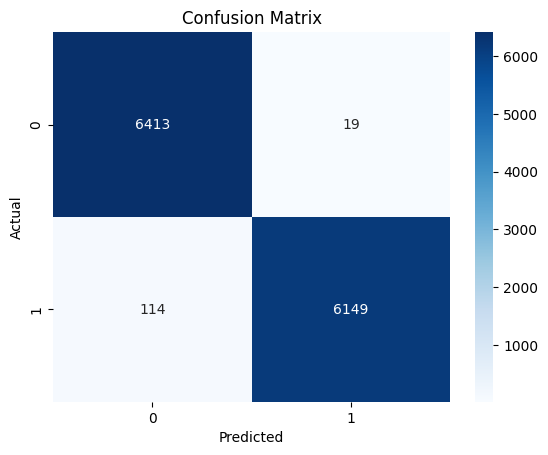

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_class, y_pred_class)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


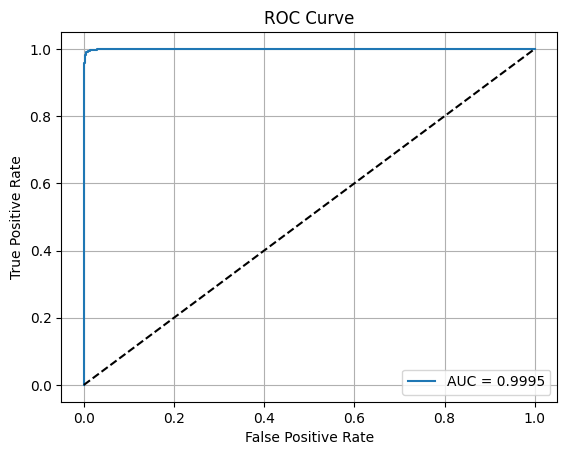

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test_class, y_pred_prob)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test_class, y_pred_prob):.4f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()


### Penjelasan
- Akurasi	= 0.9879 ---> model mengklasifikasikan hampir semua sampel dengan benar
- Precision =	0.9932 --->	dari semua prediksi kelas positif (1), 99.32% benar
- Recall	= 0.9827 --->	dari semua contoh sebenarnya kelas positif, 98.27% berhasil dideteksi
- F1 Score	= 0.9879 --->	keseimbangan yang sangat baik antara precision dan recall
- ROC = AUC	0.9991 --->	model hampir sempurna dalam membedakan antara kelas 0 dan kelas 1
<br>

### Kesimpulan model menggunakan Tensorflow  
- Sangat akurat dan seimbang: tidak hanya bagus di satu sisi (misalnya precision saja), tetapi juga recall tinggi.
- Tidak overfitting: Karena hasil di test set tetap sangat tinggi (kita juga bisa bandingkan dengan hasil di validation untuk kepastian).
- Nyaris sempurna secara ROC AUC: 0.999 artinya kurva ROC-nya hampir menempel ke sudut kiri atas (ideal classifier).

### Tahap 5 : Pembuatan Arsitektur MLP Klasifikasi di PyTorch

Pembuatan arsitektur ini menggunakan :    
- Dense layers dengan ReLU
- Dropout untuk regularisasi
- BatchNorm untuk stabilisasi
- Softmax layer di akhir



In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes, hidden_dims=[128, 64], dropout_rate=0.5):
        super(MLPClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dims[0]),
            nn.BatchNorm1d(hidden_dims[0]),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.BatchNorm1d(hidden_dims[1]),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Linear(hidden_dims[1], num_classes)
        )

    def forward(self, x):
        return self.model(x)  # output logits


### Tahap 6 : Split dan Scaling Data

In [ ]:
import pandas as pd
from collections import Counter

# Hitung jumlah sampel per kelas
class_counts = pd.Series(y).value_counts()

# Ambil hanya kelas yang jumlahnya >= 2
valid_classes = class_counts[class_counts >= 2].index
mask = pd.Series(y).isin(valid_classes)

X_filtered = X[mask]
y_filtered = y[mask]

# Lanjut split
X_train, X_val, y_train, y_val = train_test_split(
    X_filtered, y_filtered, test_size=0.2, stratify=y_filtered, random_state=42
)


In [ ]:
from sklearn.preprocessing import StandardScaler

# Gunakan data yang sudah difilter
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


### Tahap 7 : Training Loop di PyTorch

Langkah ini mencakup :    
- Inisialisasi model, optimizer, dan loss function
- Training loop per epoch
- Validasi setiap *epoch*

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Konversi data ke tensor
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)  # pastikan .values jika y_train adalah Series

X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long)

# Buat dataset dan dataloader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


In [ ]:
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score
import numpy as np

# Inisialisasi ulang model agar tidak pakai .model
model = MLPClassifier(input_dim=X_train_tensor.shape[1], num_classes=len(np.unique(y_train)))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss dan optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

# Training loop
num_epochs = 30
best_val_acc = 0.0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)

    # Validation
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()

            y_pred.extend(preds)
            y_true.extend(y_batch.numpy())

    val_acc = accuracy_score(y_true, y_pred)

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f} - Val Acc: {val_acc:.4f}")

    # Simpan model terbaik (opsional)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")


Epoch 1/30 - Loss: 5.1064 - Val Acc: 0.1359
Epoch 2/30 - Loss: 4.2675 - Val Acc: 0.1489
Epoch 3/30 - Loss: 4.0753 - Val Acc: 0.1643
Epoch 4/30 - Loss: 3.9195 - Val Acc: 0.1728
Epoch 5/30 - Loss: 3.8143 - Val Acc: 0.1887
Epoch 6/30 - Loss: 3.7509 - Val Acc: 0.1983
Epoch 7/30 - Loss: 3.7079 - Val Acc: 0.2057
Epoch 8/30 - Loss: 3.6722 - Val Acc: 0.1399
Epoch 9/30 - Loss: 3.6360 - Val Acc: 0.2061
Epoch 10/30 - Loss: 3.6151 - Val Acc: 0.1653
Epoch 11/30 - Loss: 3.5894 - Val Acc: 0.1920
Epoch 12/30 - Loss: 3.5742 - Val Acc: 0.1852
Epoch 13/30 - Loss: 3.5597 - Val Acc: 0.0891
Epoch 14/30 - Loss: 3.5419 - Val Acc: 0.1982
Epoch 15/30 - Loss: 3.5324 - Val Acc: 0.1719
Epoch 16/30 - Loss: 3.5187 - Val Acc: 0.2259
Epoch 17/30 - Loss: 3.5001 - Val Acc: 0.2082
Epoch 18/30 - Loss: 3.4947 - Val Acc: 0.1201
Epoch 19/30 - Loss: 3.4997 - Val Acc: 0.0789
Epoch 20/30 - Loss: 3.4837 - Val Acc: 0.2022
Epoch 21/30 - Loss: 3.4858 - Val Acc: 0.0941
Epoch 22/30 - Loss: 3.4681 - Val Acc: 0.1926
Epoch 23/30 - Loss:

### Tahap 8 : Evaluasi dan Visualisasi Model

Tahapan ini mencakup :    
- Akurasi
- Precision, Recall, F1-score (macro & weighted)
- Confusion Matrix
- ROC AUC (jika multi-label atau binari)

Persiapan & Prediksi

In [ ]:
import torch
import numpy as np

model.eval()

y_true, y_pred, y_prob = [], [], []

with torch.no_grad():
    for X_batch, y_batch in val_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)

        probs = torch.softmax(outputs, dim=1).cpu().numpy()
        preds = np.argmax(probs, axis=1)

        y_pred.extend(preds)
        y_true.extend(y_batch.numpy())
        y_prob.extend(probs)

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)

print("Prediksi selesai. Bentuk y_true:", y_true.shape)
print("Prediksi selesai. Bentuk y_prob:", y_prob.shape)


Prediksi selesai. Bentuk y_true: (10937,)
Prediksi selesai. Bentuk y_prob: (10937, 6131)


Evaluasi Akurasi, Precision, Recall, F1

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

print("Akurasi:", accuracy_score(y_true, y_pred))
print("Precision (macro):", precision_score(y_true, y_pred, average='macro', zero_division=0))
print("Recall (macro):", recall_score(y_true, y_pred, average='macro', zero_division=0))
print("F1 Score (macro):", f1_score(y_true, y_pred, average='macro', zero_division=0))

print("\nClassification Report:")
print(classification_report(y_true, y_pred, zero_division=0))


Akurasi: 0.1789338941208741
Precision (macro): 0.01868523110082462
Recall (macro): 0.03303370693105802
F1 Score (macro): 0.01688257533379069

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.27      0.37       686
           1       0.43      0.68      0.53      1134
           2       0.00      0.00      0.00       298
           3       0.00      0.00      0.00       236
           4       0.00      0.00      0.00       282
           5       0.00      0.00      0.00       271
           6       0.00      0.00      0.00       191
           7       0.03      0.01      0.01       251
           8       0.24      0.02      0.03       221
           9       0.12      0.22      0.15       368
          10       0.07      0.02      0.04       283
          11       0.40      0.43      0.42       321
          12       0.00      0.00      0.00       213
          13       0.00      0.00      0.00       109
          14       0.00 

### Penjelasan
Hasil
- Akurasi: 0.1789 (~17.89%)
- **Precision (macro)**: 0.0187 (~1.87%)
- **Recall (macro)**: 0.0330 (~3.30%)
- **F1 Score (macro)**: 0.0169 (~1.69%)
<br><br>

Penjelasan Sederhana

- Akurasi
  Persentase prediksi model yang benar.  
  ---> Dari seluruh data, hanya sekitar 17.9% yang diprediksi benar.

- Precision (macro)
  Seberapa sering model benar saat mengklaim suatu kelas.  
  ---> Model sering salah klaim, hanya 1.87% yang benar dari semua prediksi.

- Recall (macro)
  Seberapa baik model menemukan label yang benar.  
  ---> Dari semua label sebenarnya, hanya 3.3% yang berhasil dikenali oleh model.

- F1 Score (macro)  
  Gabungan dari precision dan recall.  
  ---> Skor F1 yang sangat rendah (1.69%) menunjukkan model masih lemah dalam membedakan antar kelas.

Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix Shape:", cm.shape)
print(cm)

Confusion Matrix Shape: (436, 436)
[[185 288   0 ...   0   0   0]
 [ 51 771   0 ...   0   0   0]
 [ 13 102   0 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]


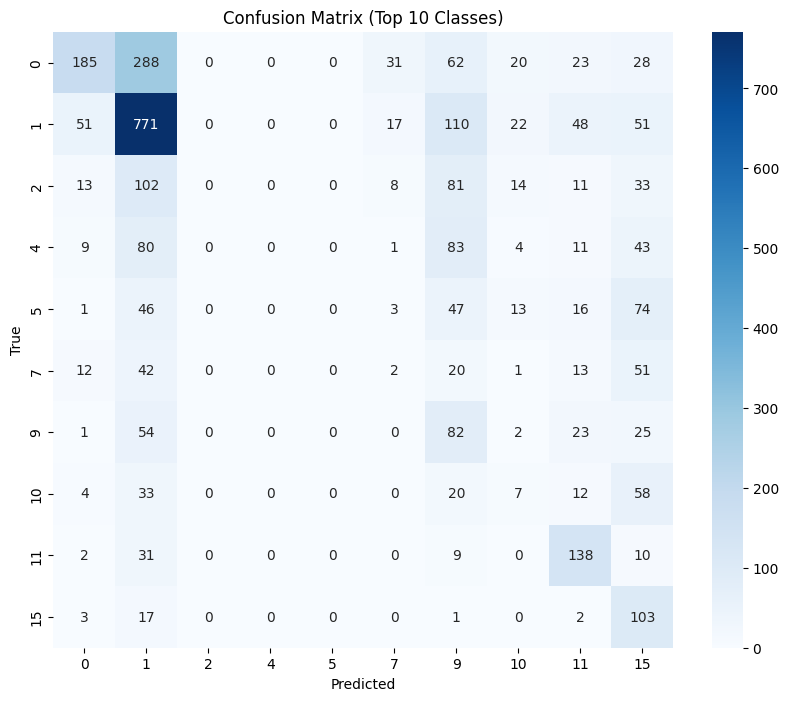

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Hitung total kemunculan tiap kelas
unique, counts = np.unique(y_true, return_counts=True)
class_counts = dict(zip(unique, counts))

# Ambil 10 kelas dengan jumlah kemunculan terbanyak
top_classes = sorted(class_counts, key=class_counts.get, reverse=True)[:10]

# Filter hanya data yang y_true-nya termasuk top_classes
mask = np.isin(y_true, top_classes)
y_true_top = np.array(y_true)[mask]
y_pred_top = np.array(y_pred)[mask]

# Filter prediksi agar hanya yang termasuk dalam top_classes
mask_pred = np.isin(y_pred_top, top_classes)
y_true_top = y_true_top[mask_pred]
y_pred_top = y_pred_top[mask_pred]

# Mapping ulang label ke 0..N untuk confusion matrix
le = LabelEncoder()
le.fit(top_classes)
y_true_enc = le.transform(y_true_top)
y_pred_enc = le.transform(y_pred_top)

# Buat confusion matrix
cm = confusion_matrix(y_true_enc, y_pred_enc)

# Visualisasi
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Top 10 Classes)')
plt.show()


ROC AUC Score

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
import numpy as np

# Ambil hanya kelas yang muncul di y_true
classes_in_true = np.unique(y_true)
print("Jumlah kelas aktif:", len(classes_in_true))

# Binarisasi label
y_true_bin = label_binarize(y_true, classes=classes_in_true)

# Filter probabilitas hanya untuk kelas yang muncul
y_prob_reduced = y_prob[:, classes_in_true]

# Hitung ROC AUC macro
try:
    roc_auc = roc_auc_score(y_true_bin, y_prob_reduced, average='macro', multi_class='ovr')
    print("ROC AUC (macro, OvR, filtered classes):", roc_auc)
except ValueError as e:
    print("Gagal menghitung ROC AUC:", e)


Jumlah kelas aktif: 436
ROC AUC (macro, OvR, filtered classes): 0.96396226336935


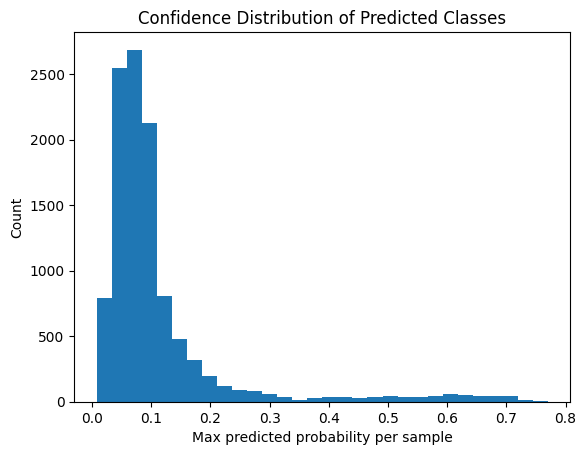

In [ ]:
import matplotlib.pyplot as plt

plt.hist(np.max(y_prob, axis=1), bins=30)
plt.title("Confidence Distribution of Predicted Classes")
plt.xlabel("Max predicted probability per sample")
plt.ylabel("Count")
plt.show()


### Penjelasan

Nilai ROC AUC (macro, OvR) setelah difilter ke kelas-kelas yang benar-benar muncul dalam data adalah **0.964**.

- ROC AUC (Receiver Operating Characteristic - Area Under Curve) mengukur seberapa baik model membedakan antar kelas.
- Macro average berarti menghitung rata-rata skor ROC AUC untuk setiap kelas, tanpa mempertimbangkan jumlah sampel di tiap kelas.
- OvR (One-vs-Rest) mengacu pada pendekatan menghitung ROC AUC untuk tiap kelas dengan menganggapnya sebagai kelas positif, dan sisanya sebagai negatif.
<br><br>

Interpretasi:

- Skor mendekati 1 berarti model memiliki kemampuan diskriminasi yang baik.
- Meskipun akurasi dan metrik lain tampak rendah, ROC AUC yang tinggi menunjukkan bahwa model mampu memberi probabilitas prediksi yang cukup baik, hanya saja threshold atau klasifikasi akhirnya belum optimal.


## Evaluasi Kinerja Model Multi-Class

Model memiliki 436 kelas aktif dan hasil evaluasi ROC AUC (macro, OvR) mencapai 0.96. Ini adalah metrik yang sangat baik dalam klasifikasi multi-kelas. Berikut penjelasan per metrik dan mana yang terbaik digunakan.
<br><br>

1. **Accuracy**
Mengukur proporsi prediksi yang benar dibandingkan total prediksi.

**Kelebihan:**
- Mudah dipahami
- Cocok jika distribusi kelas seimbang

**Kekurangan:**
- Tidak sensitif terhadap kelas minoritas
- Bisa menipu jika dataset imbalanced

**Kapan digunakan:**
- Dataset seimbang
- Tidak terlalu banyak kelas
<br><br>

2. **Precision / Recall / F1-Score (macro)**
- **Precision:** Ketepatan prediksi positif
- **Recall:** Kemampuan model menangkap seluruh label yang benar
- **F1-score:** Harmonik dari precision dan recall
- **Macro average:** Rata-rata metrik per kelas (tanpa memperhitungkan jumlah sampel)

**Kelebihan:**
- Cocok untuk multi-class dan dataset imbalance
- F1-score mempertimbangkan precision dan recall

**Kapan digunakan:**
- Saat penting untuk menilai performa semua kelas secara setara
- Ada risiko ketimpangan distribusi antar kelas
<br><br>

3. **ROC AUC (macro, OvR - One vs Rest)**
Mengukur kualitas pemisahan antara kelas yang benar dan salah dalam bentuk probabilitas.

**Kelebihan:**
- Memberi gambaran seberapa "yakin" model dalam prediksi probabilistik
- Cocok untuk multi-class (One-vs-Rest)
- Tidak tergantung pada threshold prediksi

**Kapan digunakan:**
- Model menghasilkan skor probabilitas (bukan hanya argmax label)
- Ingin mengevaluasi kualitas pemisahan probabilitas antar kelas
<br><br>

**Kesimpulan Matriks Terbaik**

| Metrik           | Cocok untuk multi-class | Memperhatikan distribusi | Gunakan jika                          |
|------------------|--------------------------|---------------------------|---------------------------------------|
| Accuracy         | Ya                       | Tidak                     | Dataset seimbang                      |
| Precision/Recall/F1 (macro) | Ya            | Ya                        | Dataset imbalanced / banyak kelas     |
| ROC AUC (macro)  | Ya                       | Ya                        | Model memberikan probabilitas, banyak kelas |

**Dalam kasus ini:**  
Karena:
- Jumlah kelas sangat banyak (436)
- Distribusi kelas kemungkinan besar tidak seimbang
- Model menghasilkan output probabilitas (softmax)

**Maka metrik terbaik untuk evaluasi adalah: ROC AUC (macro, OvR)**

Dengan skor 0.96, model memiliki kualitas pemisahan kelas yang sangat baik meskipun akurasi kasar masih rendah.

### Evaluasi dan Perbandingan Model

1. **Akurasi**  
Mengukur proporsi prediksi yang benar dibandingkan total prediksi.

- **Nilai:** 0.179  
- **Interpretasi:** Model hanya benar sekitar 17.9% dari seluruh prediksi. Ini tergolong rendah, apalagi jika jumlah kelas sangat banyak (436 kelas), sehingga prediksi acak pun bisa mendekati nilai ini.
<br><br>

2. **Precision (Macro Average)**  
Mengukur rata-rata ketepatan prediksi untuk setiap kelas, tanpa memperhatikan distribusi jumlah sampel per kelas.

- **Nilai:** 0.019  
- **Interpretasi:** Hanya sekitar 1.9% dari seluruh prediksi tiap kelas yang benar. Artinya, banyak prediksi salah sasaran.
<br><br>

3. **Recall (Macro Average)**  
Mengukur rata-rata kemampuan model untuk menemukan semua data positif dari setiap kelas.

- **Nilai:** 0.033  
- **Interpretasi:** Model hanya bisa mengenali sekitar 3.3% dari total data benar untuk setiap kelas. Kemampuan deteksi masih sangat terbatas.
<br><br>

4. **F1 Score (Macro Average)**  
Harmonic mean dari Precision dan Recall. Menggambarkan keseimbangan antara keduanya.

- **Nilai:** 0.017  
- **Interpretasi:** Skor F1 rendah menunjukkan bahwa baik precision maupun recall masih belum optimal.
<br><br>

5. **ROC AUC (Macro, One-vs-Rest, Filtered Classes)**  
Mengukur kemampuan model dalam membedakan antara satu kelas dengan lainnya, berdasarkan probabilitas prediksi.

- **Nilai:** 0.964  
- **Interpretasi:** Skor tinggi ini menunjukkan bahwa meskipun model sering salah dalam membuat keputusan akhir (kelas mana yang dipilih), probabilitas yang dihasilkannya cukup bagus dalam mengindikasikan kelas yang benar. Ini bisa dimanfaatkan untuk perbaikan threshold atau pengambilan keputusan berbasis probabilitas.
<br>

Kesimpulan:

Dalam kasus ini, **hanya satu model** yang digunakan (MLPClassifier) dan semua metrik di atas mengevaluasi performa model tersebut.

- **Model secara umum memiliki performa klasifikasi yang masih rendah** (akurasi dan f1 score rendah), terutama karena jumlah kelas sangat banyak (436 kelas) dan mungkin data tidak seimbang.
- Namun, **ROC AUC menunjukkan potensi model**—model dapat membedakan antar kelas dengan baik berdasarkan probabilitas, walaupun keputusan akhirnya belum tepat.